In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from pylab import rcParams
import plio
from plio.io.io_gdal import GeoDataset as GeoDataSet

rcParams['figure.figsize'] = 15, 15

/home/cole/miniconda3/envs/thermal/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data_prefix = '/home/cole/work/data/thermal_stuff/'

In [3]:
tir = GeoDataSet(data_prefix + 'LC08_L1GT_165198_20131110_20170428_01_T2_B10_SensorRad.TIF')
tir_data = tir.read_array()

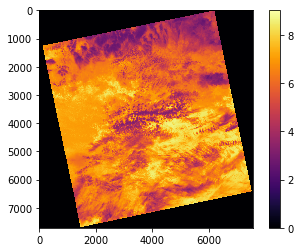

In [4]:
plt.imshow(tir_data, cmap='inferno')
plt.colorbar()

In [5]:
# arbitrary sub area, center of area
x_middle = len(tir_data) // 2
y_middle = len(tir_data[x_middle]) // 2
middle_area = ((x_middle - 15, y_middle - 15), (x_middle + 15, y_middle + 15))

tir_data[ x_middle, y_middle] = 20.0 # artificialy add hotspot because none show up with vast on this data set


In [6]:
def average_surrounding( data, x, y, size = 1):
    """
    Finds the average of surrounding pixels of point (x, y) in data 
    
    Parameters
    ----------
    data : np.array 
           array to compute average in.
    x : int 
        x coordinate
    y : int
        y coordinate
    size : int 
           defaults to 1. The amount of surrounding rings to calculate average of. At size 1 this is the 8 adjacent pixels.
             
    Returns
    -------
    : int 
      Average of surrounding pixels
    """
    # slice area around pixel and nan the center point to remove it from mean calculation
    sub_area = data[(x - size): (x + size + 1), (y - size) : (y + size + 1)]
    sub_area[size][size] = np.nan
    average = sub_area[~np.isnan(sub_area)].mean()
    return average

In [7]:
def vast( tir, corners ):
    """
    Vast computation
    
    Parameters
    ----------
    tir : np.array 
          array containing thermal infrared DNs for computing nti
    corners : tuple
              tuple containing two coordinates the top left and bottom right coordinates of a volcano area.
             
    Returns
    -------
    : np.array 
      Boolean array of pixels flagged as anomolies    
    """
    # calculate non volcano area minimum and maximum values for comparison in volcano area
    non_volc_area = tir.copy()
    non_volc_min = non_volc_area.min()

    non_volc_area[corners[0][0]:corners[1][0], corners[0][1]:corners[1][1]] = non_volc_min

    non_volc_area_max = non_volc_area.max()

    anomolies = np.empty( tir.shape )
    anomolies[:] = False
    # Is there any better way to do this to avoid iterating?
    for column in range( corners[0][0], corners[1][0] ):
        for row in range( corners[0][1], corners[1][1] ):
            if tir[column, row] - average_surrounding( tir, column, row ) > non_volc_area_max:
                anomolies[column, row] = True
    return anomolies

In [8]:
anomolies = vast( tir_data, middle_area)

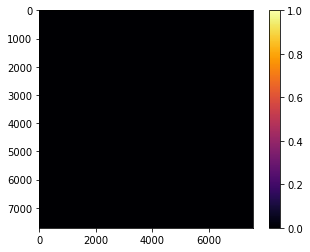

In [9]:
plt.imshow(anomolies, cmap='inferno')
plt.colorbar()

In [10]:
points = np.argwhere( anomolies == True ) # should be 3855 and 3780, the middle points
np.argwhere( anomolies == True )

array([[3855, 3780]])